# Non-linear optimization in Python

** *
*Note: if you are visualizing this notebook directly from GitHub, some mathematical symbols might display incorrectly or not display at all. This same notebook can be rendered from nbviewer by following [this link.](http://nbviewer.jupyter.org/github/david-cortes/datascienceprojects/blob/master/optimization/nonlinearopt.ipynb)*

This IPython notebook tries to showcase the usage of different optimization libraries, by finding the optimal solution of a real-valued toy function, subject to non-linear equality and inequality constraints of the variables, using different solver interfaces available for Python.

The function to minimize and the constraints are non-linear, thus the most typical algorithms such as simplex or gradient descent are not applicable.


Some of the algorithms shown here are based on jacobians and/or hessians (matrices of first and second derivatives of the function to be minimize and its non-linear constraints), which help speed up things especially in large problems (in terms of having many variables, constraints, or functions over data points), but most of the methods are an overkill for this simple example.

The choice of method and information passed to solver can, however, make a big impact on speed in bigger problems (such as calculating the parameters of some predictive model for a large dataset).


The file, unlike all the other in this page, was produced using Python 2.
** *
## Examples

[1. Derivative-free solver with NLopt](#p1)

[2. Gradient-based solver with SciPy](#p2)
* [Obtaining the derivatives](#p21)
* [Invoking the solver](#p22)

[3. KKT-based solver with CVXOPT](#p3)
* [Obtaining the jacobian and hessian](#p31)
* [Invoking the solver](#p32)

[4. Interior-point solver with Ipopt](#p4)
* [Ipopt through pyipopt](#p41)
    * [Obtaining the gradient, jacobian and hessian](#p411)
    * [Invoking the solver](#p412)
* [Ipopt through CasADi](#p42)

[5. Alternative interior-point method wtih NLopt](#p5)

[6. Benchmarking algorithms - solving a bigger problem](#p6)
* [Graphical comparison of solvability and time it took](#p61)

** *

## Mathematical formulation
** *
The goal is to solve the following mathematical problem:

$$ {min \:  x_1  x_4 ( x_1 + x_2 + x_3) + x_3} $$

$$ {s.t. \:}$$
$$ {x_1 x_2 x_3 x_4 \ge 25} $$

$$ {x_1^2 + x_2^2 + x_3^2 + x_4^2 = 40}  $$

$$ {1 \le x_1, x_2, x_3, x_4 \le 5} $$

(i.e. to find the values of $x_1, x_2, x_3$, and $x_4$ that minimize the function while respecting the constraints)

the suggested starting point for algorithms is $ x_1=1, x_2=5, x_3=5, x_4=1 $

This corresponds to problem 71 of the [Hock-Schittkowsky test suite](http://apmonitor.com/wiki/index.php/Apps/HockSchittkowski), available [here](http://apmonitor.com/wiki/uploads/Apps/hs071.apm).
** *
Note that while the function is non-convex over $\mathbb{R}^4$, all the variables are bounded to be between 1 and 5, and in that domain the function is convex and thus can be approached with a variety of methods.

In [1]:
# Proving that the function is not convex over R^4

# a function is convex if, for any number a in [0,1], it satisfies this:
# f(a*x1 + (1-a)*x2) <= a*f(x1) + (1-a)*f(x2)

import numpy as np

f=lambda x: x[0]*x[3]*(x[0]+x[1]+x[2])+x[2]
a=np.float(0.2)
x1=np.array([1,-100,2,3],dtype='float64')
x2=np.array([-1,100,2,3],dtype='float64')
f(a*x1 + (1-a)*x2) <= a*f(x1) + (1-a)*f(x2)

False

<a id='p1'></a>
## 1. Derivative-free solver (library NLopt)
** *
This problem can be easily solved by the algorithm COBYLA (Constrained Optimization BY Linear Approximations), available in the [NLopt library](http://ab-initio.mit.edu/wiki/index.php/NLopt) (among others), which comes with an interface to Python. This library can be easily installed from [conda-forge](https://anaconda.org/conda-forge/nlopt) (if using the Anaconda distribution for Python).

The library includes both derivative-based and derivate-free methods, and all of its algorithms require the functions and constraints to be passed as evaluable functions with two arguments: the variables and the gradient (not used here, and passed to me modified in-place in the function when used), even when the gradients are not used.

It can throw errors depending on the type of numbers used and outputted by functions (e.g. integers vs. floating point numbers) and the tolerances used for the objective and constraints, so oftentimes it helps to set these to values other than default. This library, as most Python-based solvers, uses NumPy's data structures.


In [2]:
import nlopt, numpy as np

############  defining the problem  ##########

# function to minimize
f0=lambda x,grad: np.float(x[0]*x[3]*(x[0]+x[1]+x[2])+x[2])

# greater-or-equal inequality constraint
## NLopt requires inequalities to be expressed as f(x)-c<=0, thus this one first has to be flipped
f1=lambda x,grad: np.float(25.0-x[0]*x[1]*x[2]*x[3])

# euqality constraint
f2=lambda x,grad: np.float(x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2 - 40.0)

# upper and lower bounds for the variables
lb=np.array([1]*4, dtype='float64')
ub=np.array([5]*4, dtype='float64')

# suggested starting point
x0=np.array([1,5,5,1], dtype='float64')


############  passing it to the solver  ##########

# initializing the optimization problem with 4 variables
opt = nlopt.opt(nlopt.LN_COBYLA,4)

# setting the function to minimize
opt.set_min_objective(f0)

# adding the constraints
opt.add_inequality_constraint(f1)
opt.add_equality_constraint(f2)

# setting the bounds for the variables
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

# setting the numerical tolerance for the objective
opt.set_xtol_rel(1e-10)

# running the solver
x = opt.optimize(x0)
minf = opt.last_optimum_value()
print "Optimal x:", x
print "Objective value:", minf
print "Result code:", opt.last_optimize_result()

Optimal x: [ 1.          4.74299965  3.82114997  1.3794083 ]
Objective value: 17.0140172892
Result code: 4


<a id='p2'></a>
## 2. Gradient-based solver (library SciPy)
** *
The problem, being a smooth, differentiable function, can be solved more easily when using the partial derivatives of the function and its non-linear constraints with respect to the variables to minimize (also known as gradient or jacobian), using algorithms such as ‘Sequential Least-Squares Programming’ (SLSQP), available in many libraries such as in SciPy's optimization module. A different implementation of the same algorithm is also available in many other libraries, such as the NLopt library used above.


The SciPy library comes installed by default with Python’s Anaconda distribution for scientific computing.

<a id='p21'></a>
### Obtaining the derivatives

The indefinite derivatives of the function and its constraints can be obtained manually or calculated with symbolic mathematics modules, such as Python’s SymPy (also installed by default in the Anaconda distribution), as shown here:

In [3]:
from sympy import symbols, diff

# This time, the functions variables will be defined as symbolic math
x=symbols('x[0] x[1] x[2] x[3]')

# function to minimize
f0=x[0]*x[3]*(x[0]+x[1]+x[2])+x[2]

# constraints
f1=x[0]*x[1]*x[2]*x[3]
f2=x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2

# derivatives of the function and the constraints
d_f0_symbols=[diff(f0,x[var]) for var in range(len(x))]
d_f1_symbols=[diff(f1,x[var]) for var in range(len(x))]
d_f2_symbols=[diff(f2,x[var]) for var in range(len(x))]

# checking some of these derivatives
print(d_f0_symbols)

[x[0]*x[3] + x[3]*(x[0] + x[1] + x[2]), x[0]*x[3], x[0]*x[3] + 1, x[0]*(x[0] + x[1] + x[2])]


These SymPy symbolic functions can be converted to evaluable functions using lambdify or passing them as a string to python's eval function:

In [4]:
from sympy.utilities.lambdify import lambdify

d_example=lambda x: x[0]*x[3] + x[3]*(x[0] + x[1] + x[2])
d_example1=lambda x: eval(str(d_f0_symbols[0]))
d_example2=lambdify(x, d_f0_symbols[0])

# some points to try
sample_points=[(1,5,5,1),(1,2,3,4),(10,10,10,10)]

print "First derivative w.r.t. x1:",str(d_f0_symbols[0])
print 
for p in sample_points:
    print "Evaluating first derivative at point",p
    print "Hard-coded function:",d_example(p)
    print "Evaluate string from sympy:",d_example1(p)
    print "Sympy's lambdify:",d_example2(*p)
    print

First derivative w.r.t. x1: x[0]*x[3] + x[3]*(x[0] + x[1] + x[2])

Evaluating first derivative at point (1, 5, 5, 1)
Hard-coded function: 12
Evaluate string from sympy: 12
Sympy's lambdify: 12

Evaluating first derivative at point (1, 2, 3, 4)
Hard-coded function: 28
Evaluate string from sympy: 28
Sympy's lambdify: 28

Evaluating first derivative at point (10, 10, 10, 10)
Hard-coded function: 400
Evaluate string from sympy: 400
Sympy's lambdify: 400



The examples below fill use the first method (evaluating sympy outputs as strings), as, while not the most efficient, it's the most convenient to write.

<a id='p22'></a>
### Invoking the solver

In [5]:
from scipy.optimize import minimize
import numpy as np

############  defining the rest of the problem  ##########

# gradient of the function
grad=lambda x: np.array(eval(str(d_f0_symbols)))

# constraints
cons=[
    {'type':'ineq','fun':lambda x: eval(str(f1))-25,'jac':lambda x: np.array(eval(str(d_f1_symbols)))},
    {'type':'eq','fun':lambda x: eval(str(f2))-40,'jac':lambda x: np.array(eval(str(d_f2_symbols)))}
]

# upper and lower bounds for the variables
lb=np.array([1]*4, dtype='float64')
ub=np.array([5]*4, dtype='float64')

# suggested starting point
x0=np.array([1,5,5,1], dtype='float64')

############  passing everything to the solver  ##########
minimize(fun=lambda x: eval(str(f0)), jac=grad, constraints=cons, bounds=[(lb[var],ub[var]) for var in range(len(x))],
        x0=x0, method='SLSQP')

     fun: 17.014017245572898
     jac: array([ 14.57227022,   1.37940764,   2.37940764,   9.56415073])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 1.        ,  4.74299606,  3.82115467,  1.37940764])

<a id='p3'></a>
## 3. KKT-based solver (library CVXOPT)

As the problem is convex in the interval to be solved, its minimum can be determined to be the point that satisfies the [Karush–Kuhn–Tucker conditions (KKT)](https://en.wikipedia.org/wiki/Karush–Kuhn–Tucker_conditions) for optimality, which in turn require solving some equations with its Jacobian(matrix of partial derivatives of the function and each non-linear constraint with respect to each variable) and Hessian (matrix of second-order partial derivates of the sum of the function and each constraint multiplied by a lagrange multiplier, with respect to each pair of variables).

<a id='p31'></a>
### Obtaining the gradient, jacobian and hessian

These will be calculated using SymPy just like in the example above:

In [6]:
from sympy import symbols, diff

x=symbols('x[0] x[1] x[2] x[3]')
z=symbols('z[0] z[1] z[2] z[3]') # these will be the lagrangian multipliers

f0=x[0]*x[3]*(x[0]+x[1]+x[2])+x[2]
f1=-(x[0]*x[1]*x[2]*x[3])

# note that CVXOPT doesn't non-linear equality constraints directly
# the original contrainf f_2(x)==40 is equivalent to these two combined:
# f_2(x)>=40 and f_3(x)<=40
f2=x[0]**2+x[1]**2+x[2]**2+x[3]**2
f3=-(x[0]**2+x[1]**2+x[2]**2+x[3]**2)
g=[f0,f1,f2,f3]
m=z[0]*f0+z[1]*f1+z[2]*f2+z[3]*f3 # this is the sum to differentiate for the hessian

jac_symbols=[[diff(g[con],x[var]) for var in range(len(x))] for con in range(len(g))]
hess_symbols=[[diff(diff(m,x[var1]),x[var2]) for var1 in range(len(x))] for var2 in range(len(x))]

<a id='p32'></a>
### Invoking the solver

In [7]:
from cvxopt import solvers, matrix
import numpy as np

ncons=len(g)-1
x0=np.array([1,5,5,1],dtype='float64')

# cvxopt requires defining a single function that outputs all the required evaluations
def F(x=None,z=None): #x is the vector of variables and z are the lagrande multipliers
    
    # when passed with no arguemnts (i.e. F()), it should return the number of non-linear constraints and astarting point
    if x is None: return ncons,matrix(x0)
    
    # when the variables are off-bounds, it should return None
    if min(x) < 1.0: return None,None
    if max(x) > 5.0: return None,None
    
    # otherwise, it needs to output the function and constraints evaluated at x
    f=matrix(np.array([
            eval(str(f0)),
            25.0+eval(str(f1)),
            eval(str(f2))-40.0,
            40.0+eval(str(f3))
        ],dtype='float64'))
    
    # and along with it, the jacobian evaluated at the same point
    Df=matrix(np.array(eval(str(jac_symbols)),dtype='float64'))
    if z is None: return f,Df
    
    # if z is provided, it also needs to output the hessian avaluated at x,z
    H=matrix(np.array(eval(str(hess_symbols)),dtype='float64'))
    return f,Df,H

######### passing this function to the solver ##########
# important to set tolerances, as otherwise it can get stuch
xsol=solvers.cp(F=F, kktsolver='ldl', options={'show_progress':False,'reltol':1e-4})
xsol

{'dual infeasibility': 0.07703721666218974,
 'dual objective': 17.077745556399535,
 'dual slack': 0.6117001389000475,
 'gap': 0.3472762664951544,
 'primal infeasibility': 0.08079169139753443,
 'primal objective': 15.95031728284468,
 'primal slack': 0.015319998875008295,
 'relative gap': 0.020335018187750183,
 'sl': <0x1 matrix, tc='d'>,
 'snl': <3x1 matrix, tc='d'>,
 'status': 'unknown',
 'x': <4x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 'zl': <0x1 matrix, tc='d'>,
 'znl': <3x1 matrix, tc='d'>}

In [8]:
print "Optimal x:",[var for var in xsol['x']]
print 'Objective value:',xsol['x'][0]*xsol['x'][3]*(xsol['x'][0]+xsol['x'][1]+xsol['x'][2])+xsol['x'][2]
print 'Z multipliers:', [var for var in xsol['znl']]

Optimal x: [1.0, 4.808364383142631, 3.9238828088666087, 1.302127362224565]
Objective value: 16.5965081735
Z multipliers: [0.6117001389000475, 1.2668465747904871, 1.0880138014153908]


_Note that this solution is quite different from what the other solvers threw and is infeasible, but close to the optimum_

<a id='p4'></a>
## 4. Interior-point solver (library Ipopt)

The problem can also be solved using interior-point methods, which are also helped by the jacobian and hessian matrices. Ipopt provides many of these, but unfortunately doesn't come with a Python interface. It is possible, however, to use third-party interfacers to it such as CasADi or pyipopt.
** *
<a id='p41'></a>
### Ipopt through pyipopt (linux only)


This library can be easily installed in 64-bit Linux systems through conda forge, first by installing [ipopt](https://anaconda.org/conda-forge/ipopt) and then [pyipopt](https://anaconda.org/imperial-college-research-computing/pyipopt) (e.g. ‘conda install -c conda-forge ipopt=3.12.7’, then ‘conda install -c imperial-college-research-computing pyipopt=0.1’). In Windows, the quickest option is to create a virtual machine under software like [VirtualBox](https://www.virtualbox.org) and run a linux environment from there).

If the installation through conda forge doesn't succeed, then in order to install this manually, the process would look like this:

1. Download the [source code for ipopt](http://www.coin-or.org/download/source/Ipopt)
2. Uncompress the file, go to the folder ‘Third Party’, and within each of those subfolder (except HSL), execute the files named ‘get.package’ (e.g. go the the folger Blas and run the command ./get.Blas, repeat for the other folders)
3. Configure the program for the local user (i.e. run ‘./configure –prefix=/usr/local’, NOT the usual ./configure’), then do ‘make’ and ‘make install’.
4. Download and install the pyipopt module for interfacing ipopt through python, which requires downloading its [source code](https://github.com/xuy/pyipopt), uncompressing, and installing with setup tools by running the setup script with the build and install commands (i.e. first ‘python setup.py build’, then ‘python setup.py install’, second one as superuser). In 32-bit anaconda installations, it might require the installation of the libgcc library for anaconda (‘conda install libgcc’).

Installing pyipopt in Python3 might require additional steps.

<a id='p411'></a>
### Obtaining the gradient, jacobian and hessian

Obtained with SymPy, just like before

In [9]:
from sympy import symbols, diff
import numpy as np

x=symbols('x[0] x[1] x[2] x[3]')

# note that ipopt requires defining the hessian slightly differently from cvxopt
# here the objective function is multiplied by a different variable than the constraints
d=symbols('d')
z=symbols('z[0] z[1]')

f0=x[0]*x[3]*(x[0]+x[1]+x[2])+x[2]
f1=x[0]*x[1]*x[2]*x[3]
f2=x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2 # ipopt supports equality constraints
g=[f1,f2]
m=d*f0 + z[0]*g[0] + z[1]*g[1]

grad=[diff(f0,x[var]) for var in range(len(x))]
jac_symbols=[[diff(g[con],x[var]) for var in range(len(x))] for con in range(len(z))]
hess_symbols=[[diff(diff(m, x[v1]), x[v2]) for v1 in range(len(x))] for v2 in range(len(x))]

<a id='p412'></a>
### Invoking the solver

In [10]:
import pyipopt

nvar=len(x)
lb=np.array([1]*4, dtype='float64')
ub=np.array([5]*4, dtype='float64')
ncon=len(g)
g_lb=np.array([25.0,40.0])
g_ub=np.array([np.inf,40.0])

eval_f=lambda x: eval(str(f0))
eval_grad_f=lambda x: np.array(eval(str(grad)))
eval_g=lambda x: np.array([eval(str(f1)),eval(str(f2))])

## ipopt requires passing the hessian and jacobian as a flat vector
## the indices of the lower triangular part to which each entry corresponds need to be passed too, these are easy to calculate

# structure of the jacobian to output
str_jac=list()
for v1 in range(ncon):
    for v2 in range(nvar):
        str_jac.append((v1,v2))
str_jac=(np.array(str_jac,dtype='int32').T[0], np.array(str_jac,dtype='int32').T[1])

# structure of the hessian to output
str_hess=list()
for v1 in range(nvar):
    for v2 in range(v1+1):
        str_hess.append((v1,v2))
str_hess=(np.array(str_hess).T[0], np.array(str_hess).T[1])

# number of entries on each
nnzj=int((len(g))*len(x))
nnzh=int(sum([i+1 for i in range(len(x))]))

# the jacobian and hessian can be passed with the argument 'flag' (true/false)
# when they are passed with a flag, they should output the structure that was calculated above

def eval_jac_g(x,flag):
    if flag==True:
        return str_jac
    else:
        return np.array(eval(str(jac_symbols)), dtype='float64').reshape((nnzj,1))
def eval_h(x,z,d,flag):
    if flag==True:
        return str_hess
    else:
        out=list()
        for v1 in range(len(x)):
            for v2 in range(v1+1):
                out.append(eval(str(hess_symbols[v1][v2])))
        return np.array(out)

# these are the number of non-duplicated non-zero entries in the jacobian and hessian
nnzj=(len(g))*len(x)
nnzh=sum([i+1 for i in range(len(x))])

# suggested starting point
x0=np.array([1,5,5,1], dtype='float64')

# solver doesn't support keywork argument, thus arguments need to be passed in this exact order
opt = pyipopt.create(nvar, lb, ub, ncon, g_lb, g_ub, nnzj, nnzh, eval_f, eval_grad_f, eval_g, eval_jac_g,eval_h,lambda x: True)
x_opt, zl, zu, constraint_multipliers, obj, status = opt.solve(x0)

print "Optimal x:",x_opt
print "Objective value:",obj
print "Bound multipliers z_L:", zl
print "Bound multipliers z_U:", zu
print "Constraint multipliers:",constraint_multipliers

Optimal x: [ 1.          4.74299964  3.82114998  1.37940829]
Objective value: 17.014017142
Bound multipliers z_L: [  1.08787122e+00   2.42877637e-10   3.22241253e-10   2.39607541e-09]
Bound multipliers z_U: [  2.27272724e-10   3.53731307e-09   7.71167542e-10   2.51089040e-10]
Constraint multipliers: [-0.55229366  0.16146856]


<a id='p42'></a>
### Ipopt through CasADi

In comparison to all the steps done before to get Ipopt running, passing this problem to it through CasADi is easier, as it does all the work of calculating gradients, jacobians and hessians instead of needing them provided. As such, here SymPy won’t be used (since casadi itself does the same).

Getting the library tu run is also a lot easier, as it comes with Ipopt prepackaged. In Windows, the process would look like this:

1. Download the [CasADi binaries](https://github.com/casadi/casadi/wiki/InstallationInstructions).
2. Unzip it, and add that directory to the Python's path variable - this can be accomplished temporarily within a Python session by executing something like this 'from sys import path;path.append("D:\\Downloads\\casadi-py35-np1.9.1-v3.1.1-64bit")'.

In Linux, it can be installed through [conda forge](https://anaconda.org/conda-forge/casadi) too ('conda install -c conda-forge casadi=3.1.1').

In [11]:
from casadi import SX, vertcat, nlpsol
import numpy as np

# casadi uses symbolic variables just like sympy - this creates an x vector with 4 values
x=SX.sym("x",4)

f0=x[0]*x[3]*(x[0]+x[1]+x[2])+x[2]
f1=x[0]*x[1]*x[2]*x[3]
f2=x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2

# note that constraints cannot be passed as a list, they need to be converted into a vector
g=vertcat(f1,f2)

# the problem is created as an object wit the variables, objective and constraints
# note that, by default, it prints all the outputs of each iteration, which results in large printout
solver = nlpsol("solver", "ipopt", {'x':x,'f':f0,'g':g}, {"print_time":False,"ipopt":{"print_level":0}})

# same information given before
x0=np.array([1,5,5,1], dtype='float64')
lb=np.array([1,1,1,1], dtype='float64')
ub=np.array([5,5,5,5], dtype='float64')
g_lb=np.array([25,40], dtype='float64')
g_ub=np.array([np.inf,40], dtype='float64')


# invoking the solver with all these parameters
res=solver(x0=x0,lbx=lb,ubx=ub,lbg=g_lb,ubg=g_ub)

print "Optimal x:" , res["x"]
print "Objective value:" , res["f"]
print "Constraint multipliers:",res['lam_g']

Optimal x: [1, 4.743, 3.82115, 1.37941]
Objective value: 17.014
Constraint multipliers: [-0.552294, 0.161469]


<a id='p5'></a>
## 5. Alternative interior-point method (NLopt)
** *
NLopt can solve problems in a manner similar to the barrier method from ipopt, by using the AUGLAG solver helped by local, less stringent solvers (either gradient-based or derivative free). In this toy example, doing this doesn’t bring any speed benefit, but it can speed things up in some situations:

In [12]:
from sympy import symbols, diff
import nlopt, numpy as np

# Building things in numpy, just like before
x=symbols('x[0] x[1] x[2] x[3]')

# function to minimize
f0=x[0]*x[3]*(x[0]+x[1]+x[2])+x[2]

# constraints
f1=25.0 - (x[0]*x[1]*x[2]*x[3]) # nlp requires constraints as <=
f2=x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2 - 40.0

# derivatives of the function and the constraints
d_f0_symbols=[diff(f0,x[var]) for var in range(len(x))]
d_f1_symbols=[diff(f1,x[var]) for var in range(len(x))]
d_f2_symbols=[diff(f2,x[var]) for var in range(len(x))]

# function to minimize
def f0(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(d_f0_symbols)), dtype='float64')
    return 1.0*x[0]*x[3]*(x[0]+x[1]+x[2])+x[2]

def f1(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(d_f1_symbols)), dtype='float64')
    return 25.0 - (x[0]*x[1]*x[2]*x[3])

def f2(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(d_f2_symbols)), dtype='float64')
    return x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2 - 40.0

# upper and lower bounds for the variables
lb=np.array([1]*4, dtype='float64')
ub=np.array([5]*4, dtype='float64')

# suggested starting point
x0=np.array([1,5,5,1], dtype='float64')


############  passing it to the solver  ##########

# initializing the solver with AUGLAG
# it comes in different varieties, the one ussing derivatives has preffix 'LD_'
opt = nlopt.opt(nlopt.LD_AUGLAG_EQ,4)

# setting the function to minimize
opt.set_min_objective(f0)

# adding the constraints
opt.add_inequality_constraint(f1)
opt.add_equality_constraint(f2)

# setting the bounds for the variables
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

# passing a local solver to AUGLAG - MMA wouldn't be able to solve this problem alone
local_opt=nlopt.opt(nlopt.LD_MMA,4)
opt.set_local_optimizer(local_opt)

# setting timeouts can help prevent crashes from approximation problems
opt.set_maxtime(10)

# running the solver
x_opt = opt.optimize(x0)
minf = opt.last_optimum_value()
print "Optimal x:", x_opt
print "Objective value:", minf
print "Result code:", opt.last_optimize_result()

Optimal x: [ 1.          4.80254926  3.8470158   1.35314458]
Objective value: 16.9042724845
Result code: 6


_Note that the solution, while close to the optimums that the other solvers found, is not feasible, but provides a reasonably good approximation._

<a id='p6'></a>
## 6. Benchmarking some algorithms with a larger problem

Now solving problem problem 103 of the [Hock-Schittkowsky test suite](http://apmonitor.com/wiki/index.php/Apps/HockSchittkowski), available [here](http://apmonitor.com/wiki/uploads/Apps/hs103.apm).


$$ {min \:\: 10\frac{x_1x_4^2x_7^{0.5}}{x_2x_6^3}+15\frac{x_3 
         x_4}{x_1x_2^2x_5x_7^{0.5}}+20\frac{x_2x_6}{x_1^2x_4x_5^2}
         +25\frac{x_1^2x_2^2x_5^{0.5}x_7}{x_3x_6^2}}$$



$$s.t.$$

$$  {  1-0.5\frac{x_1^{0.5}x_7}{x_3x_6^2}-0.7\frac{x_1^3x_2x_6x_7^{0.5}}{x_3^2 }
         -0.2\frac{x_3x_6^{\frac{2}{3}}x_7^{0.25}}{x_2x_4^{0.5}} \ge 0 }$$

$$  {    1-\frac{1.3x_2x_6}{x_1^{0.5}x_3x_5}-0.8\frac{x_3x_6^2}{x_4x_5}
         -3.1\frac{x_2^{0.5}x_6^{\frac{1}{3}}}{x_1x_4^2x_5} \ge 0 }$$

$$  {    1-2\frac{x_1x_5x_7^{\frac{1}{3}}}{x_3^1.5x_6}-0.1\frac{x_2x_5} 
             {x_3^{0.5}x_6x_7^{0.5}} - \frac{x_2x_3^{0.5}x_5}{x_1} - 
         0.65\frac{x_3x_5x_7}{x_2^2x_6} \ge 0 }$$

$$  {    1  -  0.2\frac{x_2x_5^{0.5}x_7^{\frac{1}{3}}}{x_1^2x_4}  -   0.3\frac{x_1^{0.5}x_2^2 
         x_3x_4^{\frac{1}{3}}x_7^{0.25}}{x_5^{\frac{2}{3}}}   -   0.4\frac{x_3x_5x_7^{0.75}}{ 
         x_1^3x_2^2}   -   0.5\frac{x_4x_7^{0.5}}{x_3^2} \ge 0 }$$

$$  {    10\frac{x_1x_4^2x_7^{0.5}}{x_2x_6^3}   +   15\frac{x_3 
         x_4}{x_1x_2^2x_5x_7^{0.5}}   +   20\frac{x_2x_6}{x_1^2x_4x_5^2} 
         +   25\frac{x_1^2x_2^2x_5^{0.5}x_7}{x_3x_6^2} \ge 100 }$$

$$  {    10\frac{x_1x_4^2x_7^{0.5}}{x_2x_6^3}   +   15\frac{x_3 
         x_4}{x_1x_2^2x_5x_7^{0.5}}   +   20\frac{x_2x_6}{x_1^2x_4x_5^2} 
         +   25\frac{x_1^2x_2^2x_5^{0.5}x_7}{x_3x_6^2} \le 3000 }$$


         
$$ { 0.1 \le x_1,x_2,x_3,x_4,x_5,x_6 \le 10  } $$
$$ { 0.01 \le x_7 \le 10  } $$

The best-known value is $543.667958$ and the suggested starting point is $x_1,x_2,x_3,x_4,x_5,x_6,x_7=6 $

This problem, while still smallish, is more difficult to solve than the previous one and requires more iterations within the solvers. Not all of them can find the optimum for this.

In [13]:
# symbolic math with simpy, just like before
from sympy import symbols, diff
from scipy.optimize import minimize
from cvxopt import solvers, matrix
import numpy as np, nlopt, pyipopt

# variables
x=symbols('x[0] x[1] x[2] x[3] x[4] x[5] x[6]')
z=symbols('z[0] z[1] z[2] z[3] z[4] z[5] z[6]')
l=symbols('l[0] l[1] l[2] l[3] l[4] l[5]')
d=symbols('d')

# function to minimize
# BE AWARE: in Python2, x^(1/3) is not the same as x^(1.0/3.0)
f0 = 10.0*x[0]*x[3]**2*x[6]**.5/(x[1]*x[5]**3)+15.0*x[2] \
     *x[3]/(x[0]*x[1]**2*x[4]*x[6]**0.5)+20.0*x[1]*x[5]/(x[0]**2*x[3]*x[4]**2) \
     +25.0*x[0]**2*x[1]**2*x[4]**0.5*x[6]/(x[2]*x[5]**2)
        
# non-linear constraints
f1 = 1.0-.5*x[0]**0.5*x[6]/(x[2]*x[5]**2)-.7*x[0]**3*x[1]*x[5]*x[6]**.5/x[2]**2 \
     -.2*x[2]*x[5]**(2.0/3.0)*x[6]**.25/(x[1]*x[3]**.5)#>=0

f2 = 1.0-1.3*x[1]*x[5]/(x[0]**.5*x[2]*x[4])-.8*x[2]*x[5]**2/(x[3]*x[4]) \
     -3.1*x[1]**.5*x[5]**(1.0/3.0)/(x[0]*x[3]**2*x[4])#>=0

f3 = 1.0-2.0*x[0]*x[4]*x[6]**(1.0/3.0)/(x[2]**1.5*x[5])-.1*x[1]*x[4]/ \
     (x[2]**.5*x[5]*x[6]**.5)-1.0*x[1]*x[2]**.5*x[4]/x[0]- \
     .65*x[2]*x[4]*x[6]/(x[1]**2*x[5])#>=0

f4 = 1.0-.2*x[1]*x[4]**.5*x[6]**(1.0/3.0)/(x[0]**2*x[3])-.3*x[0]**.5*x[1]**2 \
     *x[2]*x[3]**(1.0/3.0)*x[6]**.25/x[4]**(2.0/3.0)-.4*x[2]*x[4]*x[6]**.75/ \
     (x[0]**3*x[1]**2)-.5*x[3]*x[6]**.5/x[2]**2#>=0

f5 = 10.0*x[0]*x[3]**2*x[6]**.5/(x[1]*x[5]**3)+15.0*x[2] \
     *x[3]/(x[0]*x[1]**2*x[4]*x[6]**0.5)+20.0*x[1]*x[5]/(x[0]**2*x[3]*x[4]**2) \
     +25.0*x[0]**2*x[1]**2*x[4]**0.5*x[6]/(x[2]*x[5]**2)#>=100

f6 = 10.0*x[0]*x[3]**2*x[6]**.5/(x[1]*x[5]**3)+15.0*x[2] \
     *x[3]/(x[0]*x[1]**2*x[4]*x[6]**0.5)+20.0*x[1]*x[5]/(x[0]**2*x[3]*x[4]**2) \
     +25.0*x[0]**2*x[1]**2*x[4]**0.5*x[6]/(x[2]*x[5]**2)#<=3000
        
g_ge=[f0,f1,f2,f3,f4,f5,-f6]
g_le=[f0,-f1,-f2,-f3,-f4,-f5,f6]
g_ipopt=[f0,f1,f2,f3,f4,f5,f6]
m_cvxopt=z[0]*g_le[0]+z[1]*g_le[1]+z[2]*g_le[2]+z[3]*g_le[3]+z[4]*g_le[4]+z[5]*g_le[5]+z[6]*g_le[6]
m_ipopt=d*f0+l[0]*g_ipopt[1]+l[1]*g_ipopt[2]+l[2]*g_ipopt[3]+l[3]*g_ipopt[4]+l[4]*g_ipopt[5]+l[5]*g_ipopt[6]

jac_symbols=[[diff(g_ge[con],x[var]) for var in range(len(x))] for con in range(len(g_ge))]
jac_nlopt=[[diff(g_le[conn],x[varr]) for varr in range(len(x))] for conn in range(len(g_le))]
jac_ipopt=[[diff(g_ipopt[conn],x[vaarr]) for vaarr in range(len(x))] for coonn in range(len(g_ipopt))]
hess_cvxopt=[[diff(diff(m_cvxopt,x[varr1]),x[varr2]) for varr1 in range(len(x))] for varr2 in range(len(x))]
hess_ipopt=[[diff(diff(m_ipopt,x[varrr1]),x[varrr2]) for varrr1 in range(len(x))] for varrr2 in range(len(x))]

# upper and lower bounds for the variables
lb=np.array([0.1]*(len(x)-1)+[0.01],dtype='float64')
ub=np.array([10.0]*len(x),dtype='float64')

# suggested starting point
x0=np.array([6.0]*len(x),dtype='float64')

# upper and lower bounds for the constaints
c_ge=np.array([np.nan,0,0,0,0,100,-3000],dtype='float64')
g_lb=np.array([0,0,0,0,100,-np.inf],dtype='float64')
g_ub=np.array([np.inf]*5+[3000],dtype='float64')

cons_scipy=[
    {'type':'ineq','fun':lambda x: eval(str(g_ge[1]))-c_ge[1],'jac':lambda x: np.array(eval(str(jac_symbols[1])))},
    {'type':'ineq','fun':lambda x: eval(str(g_ge[2]))-c_ge[2],'jac':lambda x: np.array(eval(str(jac_symbols[2])))},
    {'type':'ineq','fun':lambda x: eval(str(g_ge[3]))-c_ge[3],'jac':lambda x: np.array(eval(str(jac_symbols[3])))},
    {'type':'ineq','fun':lambda x: eval(str(g_ge[4]))-c_ge[4],'jac':lambda x: np.array(eval(str(jac_symbols[4])))},
    {'type':'ineq','fun':lambda x: eval(str(g_ge[5]))-c_ge[5],'jac':lambda x: np.array(eval(str(jac_symbols[5])))},
    {'type':'ineq','fun':lambda x: eval(str(g_ge[6]))-c_ge[6],'jac':lambda x: np.array(eval(str(jac_symbols[6])))}
]
  
cons_ipopt=lambda x: np.array([eval(str(g_ipopt[1])),eval(str(g_ipopt[2])),eval(str(g_ipopt[3]))
                               ,eval(str(g_ipopt[4])),eval(str(g_ipopt[5])),eval(str(g_ipopt[6]))],dtype='float64')

# constraints for nlopt with in-place gradient modification
def f0_nlopt(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(jac_nlopt[0])), dtype='float64')
    return eval(str(g_le[0]))
def f1_nlopt(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(jac_nlopt[1])), dtype='float64')
    return eval(str(g_le[1]))+c_ge[1]
def f2_nlopt(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(jac_nlopt[2])), dtype='float64')
    return eval(str(g_le[2]))+c_ge[2]
def f3_nlopt(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(jac_nlopt[3])), dtype='float64')
    return eval(str(g_le[3]))+c_ge[3]
def f4_nlopt(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(jac_nlopt[4])), dtype='float64')
    return eval(str(g_le[4]))+c_ge[4]
def f5_nlopt(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(jac_nlopt[5])), dtype='float64')
    return eval(str(g_le[5]))+c_ge[5]
def f6_nlopt(x,grad):
    if grad.size>0:
        grad[:]=np.array(eval(str(jac_nlopt[6])), dtype='float64')
    return eval(str(g_le[6]))+c_ge[6]

# # formatting other necessary info
eval_f=lambda x: eval(str(f0))
eval_grad_f=lambda x: np.array(eval(str(jac_symbols[0])))

nvar=int(len(x))
ncon=int(len(g_ge)-1)

str_jac_ipopt=list()
for v1 in range(ncon):
    for v2 in range(nvar):
        str_jac_ipopt.append((v1,v2))
str_jac_ipopt=(np.array(str_jac_ipopt,dtype='int32').T[0], np.array(str_jac_ipopt,dtype='int32').T[1])

str_hess_ipopt=list()
for v1 in range(nvar):
    for v2 in range(v1+1):
        str_hess_ipopt.append((v1,v2))
str_hess_ipopt=(np.array(str_hess_ipopt,dtype='int32').T[0], np.array(str_hess_ipopt,dtype='int32').T[1])

nnzj=int((len(g_ge))*len(x))
nnzh=int(sum([i+1 for i in range(len(x))]))

def eval_jac_ipopt(x,flag):
    if flag==True:
        return str_jac_ipopt
    else:
        return np.array(eval(str(jac_ipopt)), dtype='float64').reshape((nnzj,1))
def eval_h_ipopt(x,z,d,flag):
    if flag==True:
        return str_hess_ipopt
    else:
        out=list()
        for v1 in range(len(x)):
            for v2 in range(v1+1):
                out.append(eval(str(hess_ipopt[v1][v2])))
        return np.array(out, dtype='float64')

In [14]:
# COBYLA under NLopt
opt = nlopt.opt(nlopt.LN_COBYLA,7)

# setting the function to minimize
opt.set_min_objective(f0_nlopt)

# adding the constraints
opt.add_inequality_constraint(f1_nlopt)
opt.add_inequality_constraint(f2_nlopt)
opt.add_inequality_constraint(f3_nlopt)
opt.add_inequality_constraint(f4_nlopt)
opt.add_inequality_constraint(f5_nlopt)
opt.add_inequality_constraint(f6_nlopt)

# setting the bounds for the variables
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

# setting the numerical tolerance for the objective
opt.set_xtol_rel(1e-10)

# running the solver
x = opt.optimize(x0)
print "Optimal x:", x
print "Objective value:", opt.last_optimum_value()
print "Result code:", opt.last_optimize_result()

Optimal x: [ 4.39410417  0.85446875  2.84323017  3.39997898  0.72292614  0.87040643
  0.02463883]
Objective value: 543.667958466
Result code: 4


In [15]:
%%timeit
opt.optimize(x0)

1 loop, best of 3: 36 s per loop


In [16]:
# CCSAQ under NLopt
opt = nlopt.opt(nlopt.LD_CCSAQ,7)

# setting the function to minimize
opt.set_min_objective(f0_nlopt)

# adding the constraints
opt.add_inequality_constraint(f1_nlopt)
opt.add_inequality_constraint(f2_nlopt)
opt.add_inequality_constraint(f3_nlopt)
opt.add_inequality_constraint(f4_nlopt)
opt.add_inequality_constraint(f5_nlopt)
opt.add_inequality_constraint(f6_nlopt)

# setting the bounds for the variables
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

# setting the numerical tolerance for the objective
opt.set_xtol_rel(1e-10)

# running the solver
x = opt.optimize(x0)
print "Optimal x:", x
print "Objective value:", opt.last_optimum_value()
print "Result code:", opt.last_optimize_result()

Optimal x: [ 4.39410332  0.85446887  2.84323014  3.39997727  0.72292638  0.87040641
  0.02463884]
Objective value: 543.667363053
Result code: 4


In [17]:
%%timeit
opt.optimize(x0)

1 loop, best of 3: 35.3 s per loop


In [18]:
# SLSQP under SciPy
minimize(fun=eval_f, jac=eval_grad_f, constraints=cons_scipy, bounds=[(lb[bn],ub[bn]) for bn in range(len(x))],
        x0=x0, method='SLSQP')

     fun: 543.660277163643
     jac: array([  -57.07384276, -1089.33427157,   138.87592324,   200.25885006,
        -549.76482059,  -495.11913883, -5071.04873243])
 message: 'Positive directional derivative for linesearch'
    nfev: 59
     nit: 39
    njev: 35
  status: 8
 success: False
       x: array([ 4.39408088,  0.854464  ,  2.84325329,  3.39998429,  0.72292814,
        0.87041065,  0.02464184])

In [19]:
%%timeit
minimize(fun=eval_f, jac=eval_grad_f, constraints=cons_scipy, bounds=[(lb[bn],ub[bn]) for bn in range(len(x))],
        x0=x0, method='SLSQP')

1 loop, best of 3: 4.95 s per loop


In [20]:
# CP+LDL solver under CVXOPT
def F(x=None,z=None):
    if x is None: return 6,matrix(x0)
    if max(x) >= 10.0: return None,None
    if min(x[0:6]) <= 0.1: return None,None
    if x[6] <= 0.01: return None,None
    
    f=matrix(np.array([
        eval(str(g_le[0]))+c_le[0],
        eval(str(g_le[1]))+c_le[1],
        eval(str(g_le[2]))+c_le[2],
        eval(str(g_le[3]))+c_le[3],
        eval(str(g_le[4]))+c_le[4],
        eval(str(g_le[5]))+c_le[5],
        eval(str(g_le[6]))+c_le[6]
    ],dtype='float64'))
    
    Df=matrix(np.array(eval(str(jac_nlopt)),dtype='float64'))
    if z is None: return f,Df
    
    # if z is provided, it also needs to output the hessian avaluated at x,z
    H=matrix(np.array(eval(str(hess_cvxopt)),dtype='float64'))
    return f,Df,H


options={'show_progress':True,'kktreg':1e-4,'reltol':1e-10} #setting refinement>=2 makes it loop forever
try:
    xsol=solvers.cp(F=F, kktsolver='ldl', options=options)
except:
    print "Couldn't solve problem"

     pcost       dcost       gap    pres   dres
Couldn't solve problem


In [21]:
# pyipopt crashes when trying to solve this problem

# solver doesn't support keywork argument, thus arguments need to be passed in this exact order
opt = pyipopt.create(nvar, lb, ub, ncon, g_lb, g_ub, nnzj, nnzh, eval_f, eval_grad_f, cons_ipopt, eval_jac_ipopt,eval_h_ipopt, lambda x: True)
opt.num_option('tol', 1e-10)
# opt.solve(x0) # --> this would invoke the solver, but it crashes

True

In [22]:
from casadi import SX, vertcat, nlpsol

x_casadi=SX.sym("x_casadi",7)

f0_casadi = 10.0*x_casadi[0]*x_casadi[3]**2*x_casadi[6]**.5/(x_casadi[1]*x_casadi[5]**3)+15.0*x_casadi[2] \
     *x_casadi[3]/(x_casadi[0]*x_casadi[1]**2*x_casadi[4]*x_casadi[6]**0.5)+20.0*x_casadi[1]*x_casadi[5]/(x_casadi[0]**2*x_casadi[3]*x_casadi[4]**2) \
     +25.0*x_casadi[0]**2*x_casadi[1]**2*x_casadi[4]**0.5*x_casadi[6]/(x_casadi[2]*x_casadi[5]**2)
        
# non-linear constraints
f1_casadi = 1.0-.5*x_casadi[0]**0.5*x_casadi[6]/(x_casadi[2]*x_casadi[5]**2)-.7*x_casadi[0]**3*x_casadi[1]*x_casadi[5]*x_casadi[6]**.5/x_casadi[2]**2 \
     -.2*x_casadi[2]*x_casadi[5]**(2.0/3.0)*x_casadi[6]**.25/(x_casadi[1]*x_casadi[3]**.5)#>=0

f2_casadi = 1.0-1.3*x_casadi[1]*x_casadi[5]/(x_casadi[0]**.5*x_casadi[2]*x_casadi[4])-.8*x_casadi[2]*x_casadi[5]**2/(x_casadi[3]*x_casadi[4]) \
     -3.1*x_casadi[1]**.5*x_casadi[5]**(1.0/3.0)/(x_casadi[0]*x_casadi[3]**2*x_casadi[4])#>=0

f3_casadi = 1.0-2.0*x_casadi[0]*x_casadi[4]*x_casadi[6]**(1.0/3.0)/(x_casadi[2]**1.5*x_casadi[5])-.1*x_casadi[1]*x_casadi[4]/ \
     (x_casadi[2]**.5*x_casadi[5]*x_casadi[6]**.5)-1.0*x_casadi[1]*x_casadi[2]**.5*x_casadi[4]/x_casadi[0]- \
     .65*x_casadi[2]*x_casadi[4]*x_casadi[6]/(x_casadi[1]**2*x_casadi[5])#>=0

f4_casadi = 1.0-.2*x_casadi[1]*x_casadi[4]**.5*x_casadi[6]**(1.0/3.0)/(x_casadi[0]**2*x_casadi[3])-.3*x_casadi[0]**.5*x_casadi[1]**2 \
     *x_casadi[2]*x_casadi[3]**(1.0/3.0)*x_casadi[6]**.25/x_casadi[4]**(2.0/3.0)-.4*x_casadi[2]*x_casadi[4]*x_casadi[6]**.75/ \
     (x_casadi[0]**3*x_casadi[1]**2)-.5*x_casadi[3]*x_casadi[6]**.5/x_casadi[2]**2#>=0

f5_casadi = 10.0*x_casadi[0]*x_casadi[3]**2*x_casadi[6]**.5/(x_casadi[1]*x_casadi[5]**3)+15.0*x_casadi[2] \
     *x_casadi[3]/(x_casadi[0]*x_casadi[1]**2*x_casadi[4]*x_casadi[6]**0.5)+20.0*x_casadi[1]*x_casadi[5]/(x_casadi[0]**2*x_casadi[3]*x_casadi[4]**2) \
     +25.0*x_casadi[0]**2*x_casadi[1]**2*x_casadi[4]**0.5*x_casadi[6]/(x_casadi[2]*x_casadi[5]**2)#>=100

f6_casadi = 10.0*x_casadi[0]*x_casadi[3]**2*x_casadi[6]**.5/(x_casadi[1]*x_casadi[5]**3)+15.0*x_casadi[2] \
     *x_casadi[3]/(x_casadi[0]*x_casadi[1]**2*x_casadi[4]*x_casadi[6]**0.5)+20.0*x_casadi[1]*x_casadi[5]/(x_casadi[0]**2*x_casadi[3]*x_casadi[4]**2) \
     +25.0*x_casadi[0]**2*x_casadi[1]**2*x_casadi[4]**0.5*x_casadi[6]/(x_casadi[2]*x_casadi[5]**2)#<=3000

g_casadi=vertcat(f1_casadi,f2_casadi,f3_casadi,f4_casadi,f5_casadi,f6_casadi)
solver = nlpsol("solver", "ipopt", {'x':x_casadi,'f':f0_casadi,'g':g_casadi}, {"print_time":False,"ipopt":{"print_level":0}})
res=solver(x0=x0,lbx=lb,ubx=ub,lbg=g_lb,ubg=g_ub)

print "Optimal x:" , res["x"]
print "Objective value:" , res["f"]
print "Constraint multipliers:",res['lam_g']

Optimal x: [4.3941, 0.854469, 2.84323, 3.39998, 0.722926, 0.870406, 0.0246388]
Objective value: 543.668
Constraint multipliers: [-38.705, -834.115, -1287.32, -86.7667, -4.15984e-11, 7.49225e-12]


In [23]:
%%timeit
solver(x0=x0,lbx=lb,ubx=ub,lbg=g_lb,ubg=g_ub)

10 loops, best of 3: 63.5 ms per loop


In [24]:
%%time
solver2 = nlpsol("solver", "sqpmethod", {'x':x_casadi,'f':f0_casadi,'g':g_casadi},
                {"print_time":False,'print_header':False,"qpsol":"qpoases","qpsol_options":{"printLevel":None}})
solver2(x0=x0,lbx=lb,ubx=ub,lbg=g_lb,ubg=g_ub)

iter      objective    inf_pr    inf_du     ||d|| lg(rg) ls 
   0   2.208886e+03  3.70e+02  7.37e+02  0.00e+00      -  0 
   1   1.718131e+02  3.81e+01  7.26e+02  5.99e+00      -  2 
   2   1.777915e+02  1.80e+00  1.84e+03  5.16e+00      -  1 
   3   7.070532e+02  2.30e-01  3.95e+03  1.93e+00      -  2 
   4   4.724446e+02  1.44e+00  6.00e+02  5.01e+00      -  2 
   5   3.154566e+02  9.39e-01  2.33e+02  7.25e-01      -  1 
   6   5.295164e+02  3.74e-01  3.30e+04  1.13e+00      -  1 
   7   4.593004e+02  1.05e-01  1.20e+04  1.14e+00      -  1 
   8   5.041100e+02  2.48e-02  2.43e+03  5.46e-01      -  1 
   9   5.377245e+02  5.83e-03  4.72e+02  2.88e-01      -  1 
iter      objective    inf_pr    inf_du     ||d|| lg(rg) ls 
  10   5.435357e+02  9.07e-05  8.75e+00  1.95e-02      -  1 
  11   5.436678e+02  1.33e-07  9.37e-03  1.47e-03      -  1 
  12   5.436680e+02  6.46e-14  1.57e-09  1.31e-06      -  1 

casadi::SQPMethod: Convergence achieved after 12 iterations.
CPU times: user 36 ms, 

CasADi warning: "Indefinite Hessian detected..." issued  on line 474 of file "/feedstock_root/build_artefacts/casadi_1493990261301/work/casadi-3.1.1/casadi/solvers/nlpsol/sqpmethod.cpp". 
CasADi warning: "Indefinite Hessian detected..." issued  on line 474 of file "/feedstock_root/build_artefacts/casadi_1493990261301/work/casadi-3.1.1/casadi/solvers/nlpsol/sqpmethod.cpp". 


In [25]:
# NLopt again, using the barrier method with a subsolver for the steps
opt = nlopt.opt(nlopt.LD_AUGLAG_EQ,7)
opt.set_min_objective(f0_nlopt)
opt.add_inequality_constraint(f1_nlopt)
opt.add_inequality_constraint(f2_nlopt)
opt.add_inequality_constraint(f3_nlopt)
opt.add_inequality_constraint(f4_nlopt)
opt.add_inequality_constraint(f5_nlopt)
opt.add_inequality_constraint(f6_nlopt)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-8)
opt.set_ftol_rel(1e-8)

local_opt=nlopt.opt(nlopt.LD_MMA,7)
opt.set_local_optimizer(local_opt)

# without timeouts, the problem keeps running forever, even though it finds a very close solution quickly
opt.set_maxtime(12)
local_opt.set_maxtime(3)

# running the solver
x_opt = opt.optimize(x0)
print "Optimal x:", x_opt
print "Objective value:", opt.last_optimum_value()
print "Result code:", opt.last_optimize_result()

Optimal x: [ 4.36934493  0.85524092  2.82597494  3.40489232  0.71959112  0.86944466
  0.02491629]
Objective value: 543.741442602
Result code: 6


In [26]:
# now CCSAQ sped up by AUGLAG
opt = nlopt.opt(nlopt.LD_AUGLAG_EQ,7)
opt.set_min_objective(f0_nlopt)
opt.add_inequality_constraint(f1_nlopt)
opt.add_inequality_constraint(f2_nlopt)
opt.add_inequality_constraint(f3_nlopt)
opt.add_inequality_constraint(f4_nlopt)
opt.add_inequality_constraint(f5_nlopt)
opt.add_inequality_constraint(f6_nlopt)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-10)

local_opt=nlopt.opt(nlopt.LD_CCSAQ,7)
opt.set_local_optimizer(local_opt)

# without timeouts, the problem keeps running forever, even though it finds a very close solution
opt.set_maxtime(12)
local_opt.set_maxtime(5)

# running the solver
x_opt = opt.optimize(x0)
print "Optimal x:", x_opt
print "Objective value:", opt.last_optimum_value()
print "Result code:", opt.last_optimize_result()

Optimal x: [ 4.37136362  0.85519012  2.83038739  3.41127838  0.72157477  0.8714048
  0.0248745 ]
Objective value: 543.715566101
Result code: 6


In [27]:
# again AUGLAG, this time with the same COBYLA used at the beginning
opt = nlopt.opt(nlopt.LD_AUGLAG_EQ,7)
opt.set_min_objective(f0_nlopt)
opt.add_inequality_constraint(f1_nlopt)
opt.add_inequality_constraint(f2_nlopt)
opt.add_inequality_constraint(f3_nlopt)
opt.add_inequality_constraint(f4_nlopt)
opt.add_inequality_constraint(f5_nlopt)
opt.add_inequality_constraint(f6_nlopt)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-10)

local_opt=nlopt.opt(nlopt.LN_COBYLA,7)
opt.set_local_optimizer(local_opt)

# without timeouts, the problem keeps running forever, even though it finds a very close solution
opt.set_maxtime(25)
# local_opt.set_maxtime(5)

# running the solver
x_opt = opt.optimize(x0)
print "Optimal x:", x_opt
print "Objective value:", opt.last_optimum_value()
print "Result code:", opt.last_optimize_result()

Optimal x: [ 4.38986518  0.85466028  2.84093624  3.40306186  0.7228384   0.87082528
  0.02467284]
Objective value: 543.668350561
Result code: 6


<a id='p61'></a>
## Graphical comparison of solvability and time it took

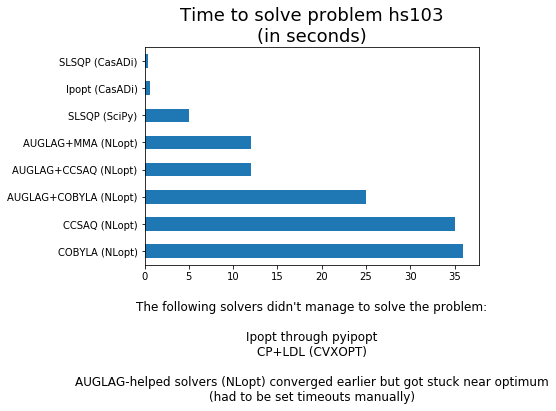

In [28]:
import matplotlib.pyplot as plt, pandas as pd
%matplotlib inline

times=pd.DataFrame.from_dict({"SLSQP (SciPy)":5,"COBYLA (NLopt)":36, "CCSAQ (NLopt)":35, "Ipopt (CasADi)":0.6,'SLSQP (CasADi)':0.4,
                              'AUGLAG+MMA (NLopt)':12,"AUGLAG+COBYLA (NLopt)":25,'AUGLAG+CCSAQ (NLopt)':12},orient='index')
times=times.rename(columns={0:'time'}).sort_values('time',ascending=False)
times.plot(kind='barh',legend=False)
_=plt.title("Time to solve problem hs103\n(in seconds)",size=18)
_=plt.xlabel("\nThe following solvers didn't manage to solve the problem:\n\n"+
                "Ipopt through pyipopt\n"+
              "CP+LDL (CVXOPT)\n\n"+
            "AUGLAG-helped solvers (NLopt) converged earlier but got stuck near optimum\n"+
            "(had to be set timeouts manually)",size=12)

_Note: the comparison between CasADi and the others is not entirely fair, because the other solvers had all the functions and derivatives calculated in sympy objects, which at each evaluation had to be transformed into text and then evaluated, adding some extra overhead._